# Sun Spot Analysis

This exercise and data is from Mark Newman's text, 'Computational Physics'.

See: <https://public.websites.umich.edu/~mejn/cp/index.htm>

See also: <https://www.swpc.noaa.gov/products/solar-cycle-progression>

## Exercise 3.1: Plotting experimental data
In the on-line resources you will find a file called sunspots.txt, which contains the observed
number of sunspots on the Sun for each month since January 1749. The file contains two
columns of numbers, the first being the month and the second being the sunspot number.

 a. Write a program that reads in the data and makes a graph of sunspots as a function of
time.

 b. Modify your program to display only the first 1000 data points on the graph.
 
 c. Modify your program further to calculate and plot the running average of the data, defined by
$$Y_k=\frac{1}{2r} \sum^r_{m=-r} y_{k+m} \leftarrow \text{ for N intervals }, N=(k-2r) $$
where $r = 5$ in this case (and the $y_k$ are the sunspot numbers). Have the program plot
both the original data and the running average on the same graph, again over the range
covered by the first 1000 data points.

## Use Python standard libraries

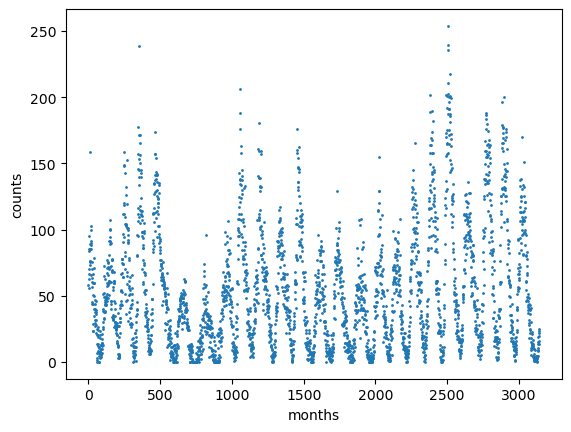

In [1]:
# use numpy.loadtxt (method 0)
import numpy as np
import matplotlib.pyplot as plt

# we shall assume that our data is not missing any values
data = np.loadtxt('sunspots.txt',float)
months=data[:,0].astype(int)
counts=data[:,1].astype(float)

plt.scatter(x=months, y=counts, s=1)
plt.ylabel('counts')
plt.xlabel('months')
plt.show()

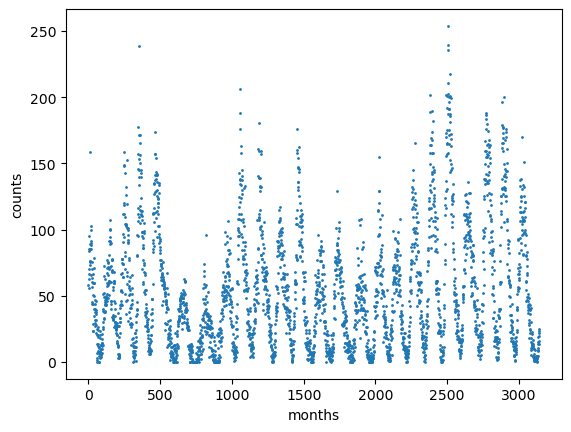

In [2]:
# use Context Manager to open file (method 1)
import numpy as np
import matplotlib.pyplot as plt

# we assuming that that our data is not missing any values
months = []
counts = []
with open('sunspots.txt', 'r') as reader:
    line = reader.readline()
    while line != '':  # The EOF char is an empty string
        #print(line, end='')
        #print(line.split()[1])
        months.append(line.split()[0])
        counts.append(line.split()[1])
        line = reader.readline()
months = np.array(months).astype(int) # convert from string to float
counts = np.array(counts).astype(float) # convert from string to float

plt.scatter(x=months, y=counts, s=1)
plt.ylabel('counts')
plt.xlabel('months')
plt.show()

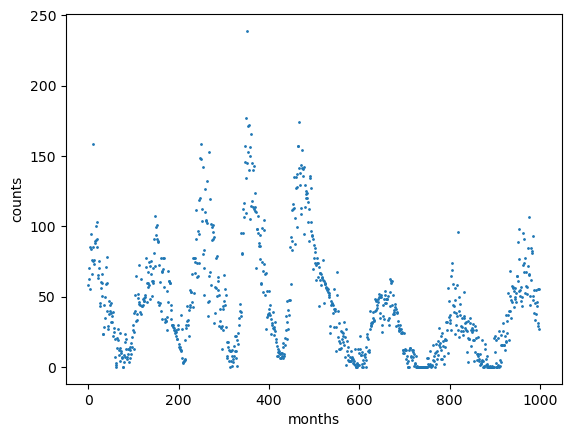

In [3]:
# display only the first 1000 data points on the graph.
plt.scatter(x=months[:1000], y=counts[:1000], s=1)
plt.ylabel('counts')
plt.xlabel('months')
plt.show()

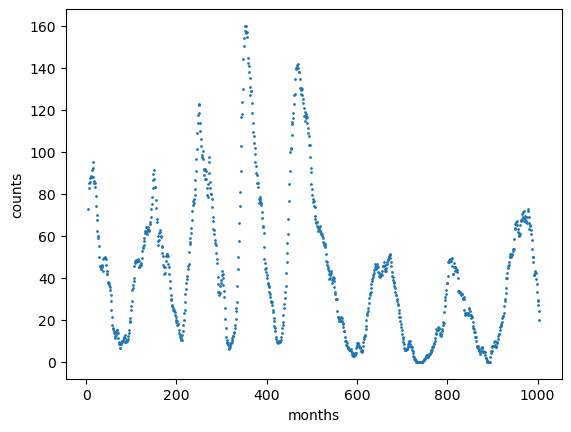

array([72.73, 82.79, 85.05])

In [4]:
# calculate and plot the running average of the data
r = 5
y = []
for k in range(r,len(counts)-r):
    sum = 0
    for m in range(-r,r):
        sum += counts[k+m]
        #print(m,sum)
    Y_k = 1/(2*r) * sum
    y.append(Y_k)
y = np.array(y)

plt.scatter(x=months[r:1000+r], y=y[:1000], s=1)
plt.ylabel('counts')
plt.xlabel('months')
plt.show()
y[:3]

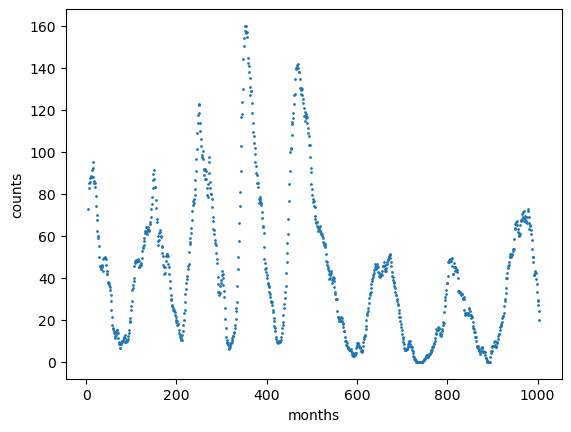

(array([72.73, 82.79, 85.05]), False)

In [5]:
# this is really a convolution, so let's do that
r = 5
y = np.convolve(counts, np.ones(2*r)/(2*r), mode='valid')

plt.scatter(x=months[r:1000+r], y=y[:1000], s=1)
plt.ylabel('counts')
plt.xlabel('months')
plt.show()

# note that 'y' is now truncated by 2*r
y[:3], months.shape==y.shape

## Use Pandas and Data Science libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# use pandas (method 2)
df = pd.read_csv('sunspots.txt', delimiter='\t', header=None, names=['month','count'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   3143 non-null   int64  
 1   count   3143 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.2 KB


In [9]:
df.describe()

,month,count
count,3143.000000,3143.000000
mean,1571.000000,51.924499
std,907.450274,44.322387
min,0.000000,0.000000
25%,785.500000,15.450000
50%,1571.000000,41.500000
75%,2356.500000,76.500000
max,3142.000000,253.800000


Use the `datatime` library to convert our months to dates. 

In [10]:
from datetime import datetime, timedelta

df['date'] = pd.to_datetime(df['month'].apply(lambda x: datetime(1749, 1, 1) + pd.DateOffset(months=x)))
#df.set_index('date', inplace=True)
df.head()

,month,count,date
0,0,58.0,1749-01-01
1,1,62.6,1749-02-01
2,2,70.0,1749-03-01
3,3,55.7,1749-04-01
4,4,85.0,1749-05-01


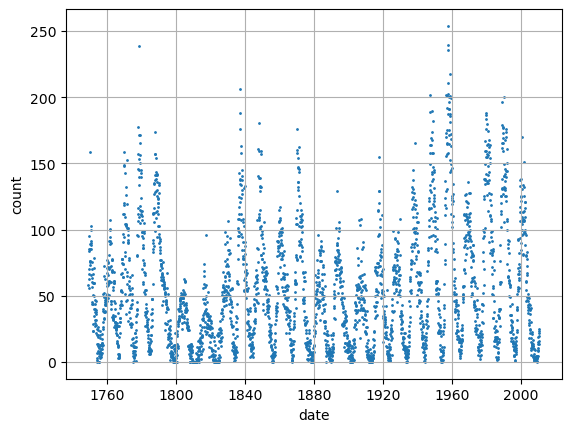

In [11]:
df.plot(kind='scatter', x="date", y="count", s=1)
plt.grid()

5    72.73
6    82.79
7    85.05
Name: conv, dtype: float64

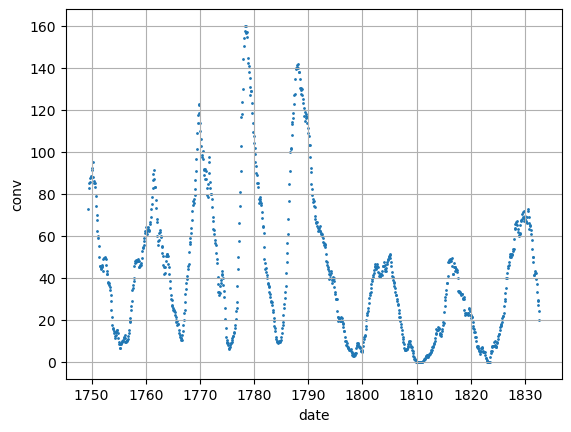

In [12]:
r = 5

# Define a kernel for our convolution
kernel = np.ones(2*r)/(2*r)

# Apply np.convolve on the count column of our DataFrame
df['conv'] = np.convolve(df['count'], kernel, 'same')
df.iloc[r:1000+r].plot(kind='scatter', x="date", y="conv", s=1)
plt.grid()

# recall that we truncated our 'y' indexes by 2*r above, do the same for comparison
df.iloc[r:r+3]['conv']

### Now let's use `np.fft` to explore the frequency spectrum of our data. 

In [13]:
df['month'].to_numpy().shape, df['conv'].to_numpy().shape, months.shape

((3143,), (3143,), (3143,))

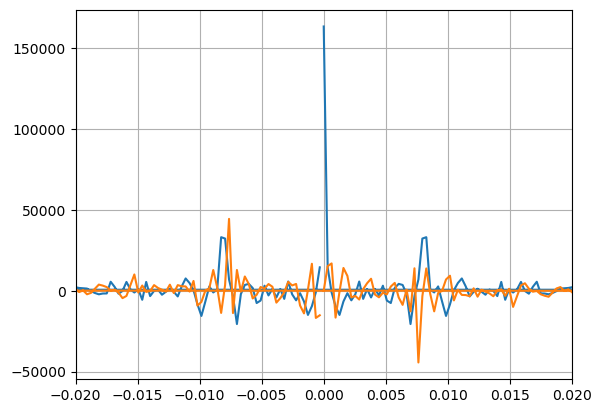

In [14]:
# use original data
t = months
sp = np.fft.fft(counts)

# use convolution data, (shows the same results)
#t = df['month'].to_numpy()
#sp = np.fft.fft(df['conv'].to_numpy())

freq = np.fft.fftfreq(t.shape[-1])

plt.plot(freq, sp.real, freq, sp.imag)
plt.xlim(-0.02,0.02)
plt.grid()
plt.show()

In [15]:
# get peak freq
peak_index = np.argmax(sp.imag)
peak_freq = freq[peak_index]
period_in_years = np.abs(1/peak_freq /12)
print(f'The calculated sunspot cycles is approximately {round(period_in_years,1)} years.')

The calculated sunspot cycles is approximately 10.9 years.


### Now let's try to see if there is any modulation to the cycles that might be of interest.

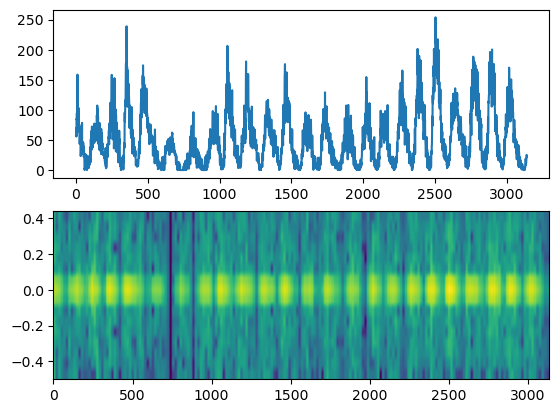

In [16]:
x = counts  # the signal
t = months
dt = 1/1
NFFT = 2**4  # the length of the windowing segments
Fs = int(1.0 / dt)  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(t, x)
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=0, sides='twosided', detrend='none')
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

Observations:
We note some variation in the period of the cycles. Between months 500 to 1000 the periods where somewhat longer.  More recent cycles seems to be more regular.

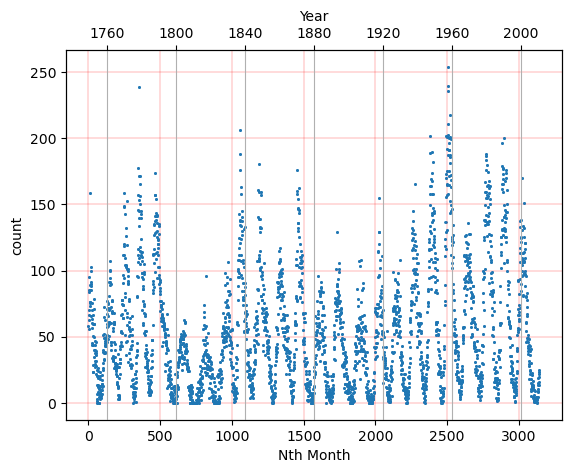

In [17]:
# Create a figure and axis
fig, ax1= plt.subplots()

# Plot the data using the index on the x-axis
df.plot(kind='scatter', x='month', y='count', ax=ax1, legend=False, s=1)
ax1.set_xlabel('Nth Month')
plt.grid(color='r', linestyle='-', linewidth=.2) # multiple grid might be confusing but helps to relate the two scales.

# Create a second x-axis that shares the same y-axis
ax2 = ax1.twiny()

# Plot the data using the Date on the new x-axis
df.plot(kind='scatter', x='date', y='count', ax=ax2, legend=False, s=1)
ax2.set_xlabel('Year')

# Hide the first x-axis
#ax1.xaxis.set_visible(False)
plt.grid()
plt.show()

In [18]:
#!pip install sounddevice

In [19]:
# let's do something silly
import numpy as np
import sounddevice as sd
from scipy.signal import butter, lfilter

# Define our low pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Parameters for filtering and playback
fs = 44100  # sample rate
secs = 2  # desired play time
order = 10
cutoff = 1000  # desired cutoff frequency of the filter, Hz

# Repeat the array to make it 1 sec long
time_data = np.repeat(y, fs//len(counts) *secs )

# Normalize the array to -1.0 to 1.0 range
time_data = time_data / np.max(np.abs(time_data))

# Apply our filter
filtered_data = butter_lowpass_filter(time_data, cutoff, fs, order)

# Play our audio
sd.play(filtered_data, fs)

# Wait for the sound to finish
sd.wait();

## Appendix 0. Using numpy.fft()

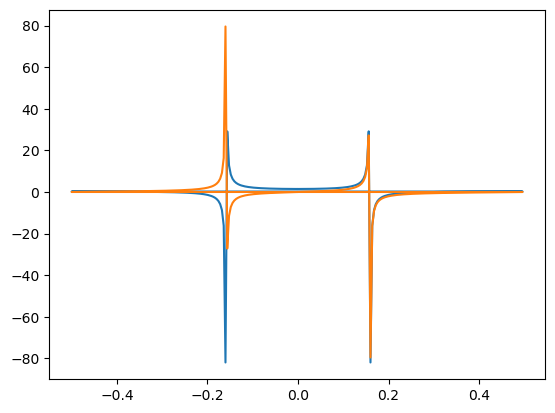

In [20]:
# Recall np.fft 
import matplotlib.pyplot as plt

t = np.arange(256)
sp = np.fft.fft(np.sin(t))

freq = np.fft.fftfreq(t.shape[-1])

plt.plot(freq, sp.real, freq, sp.imag)
plt.show()

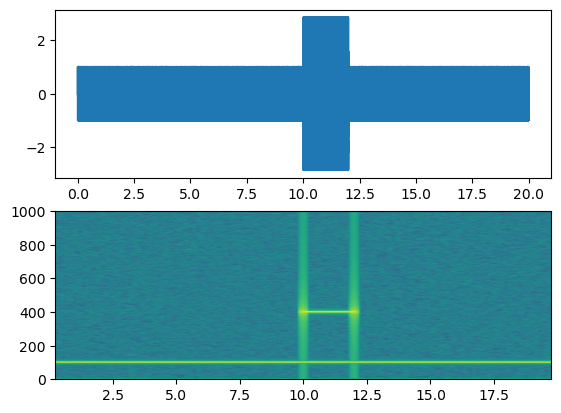

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

dt = 0.0005
t = np.arange(0.0, 20.0, dt)
s1 = np.sin(2 * np.pi * 100 * t)
s2 = 2 * np.sin(2 * np.pi * 400 * t)

# create a transient "chirp"
s2[t <= 10] = s2[12 <= t] = 0

# add some noise into the mix
nse = 0.01 * np.random.random(size=len(t))

x = s1 + s2 + nse  # the signal
NFFT = 1024  # the length of the windowing segments
Fs = int(1.0 / dt)  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(t, x)
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()